Generate a set of random string sequences that follow a specified format, and add a few anomalies. We're gonna start by writing a function that creates strings of the following format: CEBF0ZPQ ([4 letters A-F][1 digit 0–2][3 letters QWOPZXML]), and generate 25K sequences of this format.

In [3]:
import random
import pandas as pd
first_letters =  'ABCDEF'
second_numbers = '120'
last_letters = 'QWOPZXML'
# returns a string of the following format: [4 letters A-F][1 digit 0-2][3 letters QWOPZXML]
def get_random_string():
    str1 = ''.join(random.choice(first_letters) for i in range(4))
    str2 = random.choice(second_numbers)
    str3 = ''.join(random.choice(last_letters) for i in range(3))
    return str1+str2+str3
# get 25,000 sequences of this format
random_sequences = [get_random_string() for i in range(25000)]
#this will return string according to the following format
# ['CBCA2QOM', 'FBEF0WZW', 'DBFB2ZML', 'BFCB2WXO']
# add some anomalies to our list
random_sequences.extend(['XYDC2DCA', 'TXSX1ABC','RNIU4XRE','AABDXUEI','SDRAC5RF'])
#save this to a dataframe
seqs_ds = pd.DataFrame(random_sequences)

Encode the string sequences into numbers and scale them

In [4]:
import numpy as np
#Build the char index that we will use to encode seqs to numbers 
#(this char index was written by Jason Brownlee from Machine Learning Mastery)
char_index = '0abcdefghijklmnopqrstuvwxyz'
char_index +='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
char_index += '123456789'
char_index += '().,-/+=&$?@#!*:;_[]|%⸏{}\"\'' + ' ' +'\\'
char_to_int = dict((c, i) for i, c in enumerate(char_index))
int_to_char = dict((i, c) for i, c in enumerate(char_index))
from tensorflow.keras.preprocessing.sequence import pad_sequences
#function that convert a char seqs to numbers seqs 
#(it does a little more but lets leave it for now)
def encode_sequence_list(seqs, feat_n=0):
    encoded_seqs = []
    for seq in seqs:
        encoded_seq = [char_to_int[c] for c in seq]
        encoded_seqs.append(encoded_seq)
    if(feat_n > 0):
        encoded_seqs.append(np.zeros(feat_n))
    return pad_sequences(encoded_seqs, padding='post')

def decode_sequence_list(seqs):
    decoded_seqs = []
    for seq in seqs:
        decoded_seq = [int_to_char[i] for i in seq]
        decoded_seqs.append(decoded_seq)
    return decoded_seqs
    
# Using the char_index, the encode_sequence_list function
# will turn a string like this EBCA0OXO 
#to an array like this [29 32 27 27  0 42 42 38]

# encode each string seq to an integer array [[1],[5],[67]], [[45],[76],[7]
encoded_seqs = encode_sequence_list(random_sequences)
# mix everything up
np.random.shuffle(encoded_seqs)
encoded_seqs.shape

(25005, 8)

In [5]:
print(random_sequences[10])
print(encoded_seqs[10])

FBDC2XQZ
[31 27 30 28 54 41 49 43]


Now we have an array of the following shape as every string sequence has 8 characters, each of which is encoded as a number which we will treat as a column. Finally, before feeding the data to the autoencoder I'm going to scale the data using a MinMaxScaler, and split it into a training and test set. Proper scaling can often significantly improve the performance of NNs so it is important to experiment with more than one method.

In [6]:
#Scale our data using a MinMaxScaler that will scale 
#each number so that it will be between 0 and 1
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaled_seqs = scaler.fit_transform(encoded_seqs)
#Create a test and train sets of our data
X_train = scaled_seqs[:20000]
X_test = scaled_seqs[20000:]

Design, fit and tune the autoencoder.
As mentioned earlier, there is more than one way to design an autoencoder. It is usually based on small hidden layers wrapped with larger layers (this is what creates the encoding-decoding effect). I have made a few tuning sessions in order to determine the best params to use here as different kinds of data usually lend themselves to very different best-performance parameters.

In [7]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

input_dim = X_train.shape[1] # the # features
encoding_dim = 8 # first layer
hidden_dim = int(encoding_dim / 2) #hideen layer

nb_epoch = 30
batch_size = 128
learning_rate = 0.1

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
#create callback
filepath = 'my_best_model.hdf5'
checkpointer = ModelCheckpoint(filepath=filepath,                             
                             verbose=0, 
                             save_best_only=True)

tensorboard = TensorBoard(log_dir='/tmp/autoencoder', histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

2022-10-17 20:48:20.009033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-17 20:48:20.052134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-17 20:48:20.052731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-17 20:48:20.053628: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Epoch 1/30
157/157 [==============================] - 2s 7ms/step - loss: 0.1491 - accuracy: 0.0849 - val_loss: 0.0860 - val_accuracy: 0.0563
Epoch 2/30
157/157 [==============================] - 1s 6ms/step - loss: 0.0491 - accuracy: 0.1408 - val_loss: 0.0286 - val_accuracy: 0.2338
Epoch 3/30
157/157 [==============================] - 1s 6ms/step - loss: 0.0225 - accuracy: 0.3442 - val_loss: 0.0177 - val_accuracy: 0.6122
Epoch 4/30
157/157 [==============================] - 1s 6ms/step - loss: 0.0147 - accuracy: 0.6489 - val_loss: 0.0128 - val_accuracy: 0.6593
Epoch 5/30
157/157 [==============================] - 1s 6ms/step - loss: 0.0117 - accuracy: 0.6614 - val_loss: 0.0103 - val_accuracy: 0.7121
Epoch 6/30
157/157 [==============================] - 1s 7ms/step - loss: 0.0095 - accuracy: 0.7336 - val_loss: 0.0089 - val_accuracy: 0.7383
Epoch 7/30
157/157 [==============================] - 1s 7ms/step - loss: 0.0086 - accuracy: 0.7386 - val_loss: 0.0082 - val_accuracy: 0.7393
Epoch 

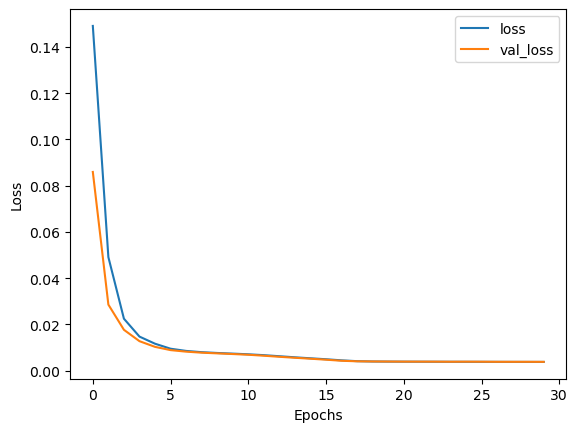

In [8]:
from matplotlib import pyplot as plt 
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show(block=False)

In [9]:
autoencoder = load_model(filepath)
print(f"Min Loss:{np.min(history['loss'])}")

Min Loss:0.003793644020333886


Calculate the Error and Find the Anomalies!
Now, we feed the data again as a whole to the autoencoder and check the error term on each sample. Recall that seqs_ds is a pandas DataFrame that holds the actual string sequences. Line #2 encodes each string, and line #4 scales it. Then, I use the predict() method to get the reconstructed inputs of the strings stored in seqs_ds. Finally, I get the error term for each data point by calculating the “distance” between the input data point (or the actual data point) and the output that was reconstructed by the autoencoder:
`mse = np.mean(np.power(actual_data - reconstructed_data, 2), axis=1)`

In [10]:
#encode all the data
encoded_seqs = encode_sequence_list(seqs_ds.iloc[:,0])
#scale it
scaled_data = MinMaxScaler().fit_transform(encoded_seqs)
#predict it
predicted = autoencoder.predict(scaled_data)
#get the error term
mse = np.mean(np.power(scaled_data - predicted, 2), axis=1)
#now add them to our data frame
seqs_ds['MSE'] = mse
display(seqs_ds)

782/782 [==============================] - 2s 2ms/step


,0,MSE
0,FEAD2MWW,0.004324
1,BDAA1LQM,0.005056
2,BFFB1WQP,0.004876
3,DACE2POQ,0.002331
4,FFEA2OWP,0.005022
...,...,...
25000,XYDC2DCA,0.248156
25001,TXSX1ABC,0.375250
25002,RNIU4XRE,0.181715
25003,AABDXUEI,0.012054


After we store the error term in the data frame, we can see how well each input data was constructed by our autoencoder.

How do we find the anomalies?
Well, the first thing we need to do is decide what is our threshold, and that usually depends on our data and domain knowledge. Some will say that an anomaly is a data point that has an error term that is higher than 95% of our data, for example. That would be an appropriate threshold if we expect that 5% of our data will be anomalous. However, recall that we injected 5 anomalies to a list of 25,000 perfectly formatted sequences, which means that only 0.02% of our data is anomalous, so we want to set our threshold as higher than 99.98% of our data (or the 0.9998 percentile). So first let's find this threshold:

In [11]:
mse_threshold = np.quantile(seqs_ds["MSE"], 0.9998)
print(f"MSE 0.9998 threshold:{mse_threshold}")

MSE 0.9998 threshold:0.008634132444982732


Next, I will add an MSE_Outlier column to the data set and set it to 1 when the error term crosses this threshold.

In [12]:
seqs_ds['MSE_Outlier'] = 0
seqs_ds.loc[seqs_ds['MSE'] > mse_threshold, 'MSE_Outlier'] = 1

And now all we have to do is check how many outliers do we have and whether these outliers are the ones we injected and mixed in the data
['XYDC2DCA', 'TXSX1ABC','RNIU4XRE','AABDXUEI','SDRAC5RF']. So let's see how many outliers we have and whether they are the ones we injected.

In [13]:
print(f"NUm of MSE Outlier:{seqs_ds['MSE_Outlier'].sum()}")
seqs_ds.iloc[25000:]

NUm of MSE Outlier:6


,0,MSE,MSE_Outlier
25000,XYDC2DCA,0.248156,1
25001,TXSX1ABC,0.375250,1
25002,RNIU4XRE,0.181715,1
25003,AABDXUEI,0.012054,1
25004,SDRAC5RF,0.155238,1
